In [107]:
import pandas as pd
import uproot
import numpy as np
import cmath
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import moments
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["font.family"] = "serif"
plt.rcParams["text.usetex"] = True
obsList = ['FL', 'S3', 'S4', 'S5', 'AFB', 'S7', 'S8', 'S9']
obs_to_label = {'FL' : '$F_{L}$', 'S3' : '$S_{3}$', 'S4' : '$S_{4}$', 'S5' : '$S_{5}$', 'AFB' : '$A_{FB}$', 'S7' : '$S_{7}$', 'S8' : '$S_{8}$', 'S9' : '$S_{9}$'}

In [100]:
infile = uproot.open('dataset_bin_8.root')['DecayTree'].arrays(library = 'pd')
infile = moments.calculateAllMoments(infile)

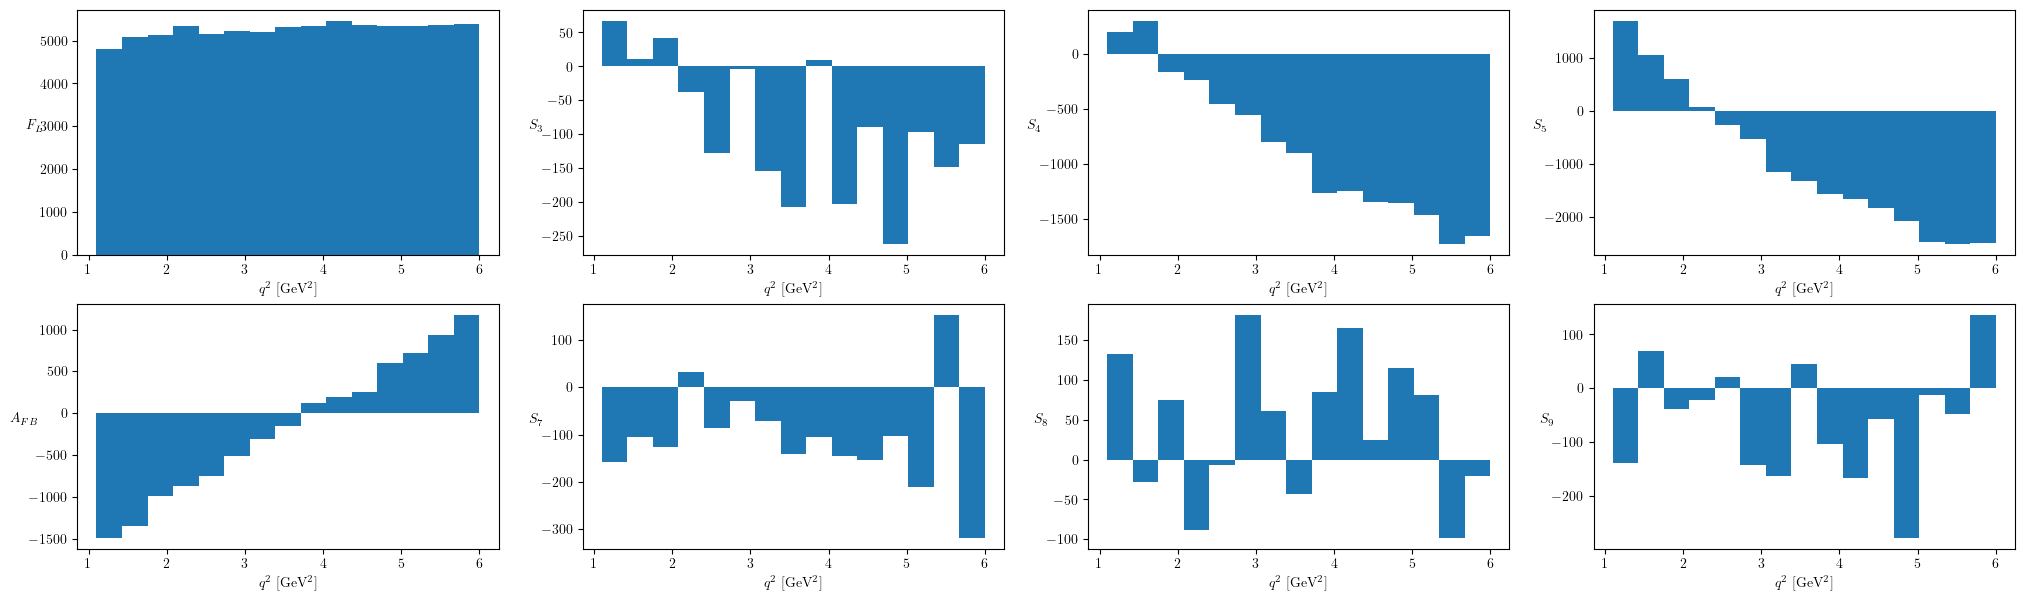

In [113]:
mom_bins = {}
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (25,7))
_i = 0
for _row in ax:
    for _col in _row:
        mom_bins[obsList[_i]] = _col.hist(infile['q2'], weights = infile['moment_%s' % obsList[_i]], bins = 15)
        _col.set_xlabel("$q^{2}$ [GeV$^{2}$]")
        _col.set_ylabel(obs_to_label[obsList[_i]], rotation=0)
        _i += 1

Text(0.5, 0, '$q^{2}$ [GeV$^{2}$]')

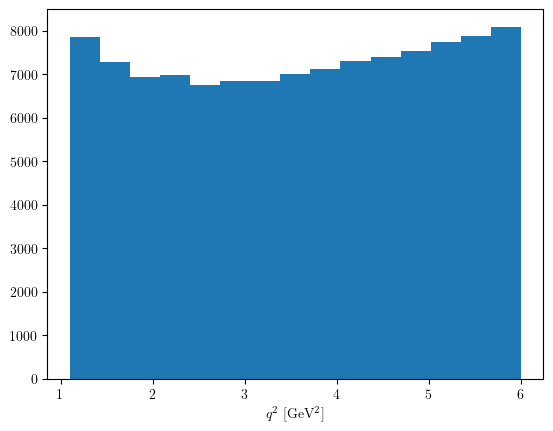

In [112]:
plt.figure()
r_bins = plt.hist(infile['q2'], bins = 15)
plt.xlabel("$q^{2}$ [GeV$^{2}$]")

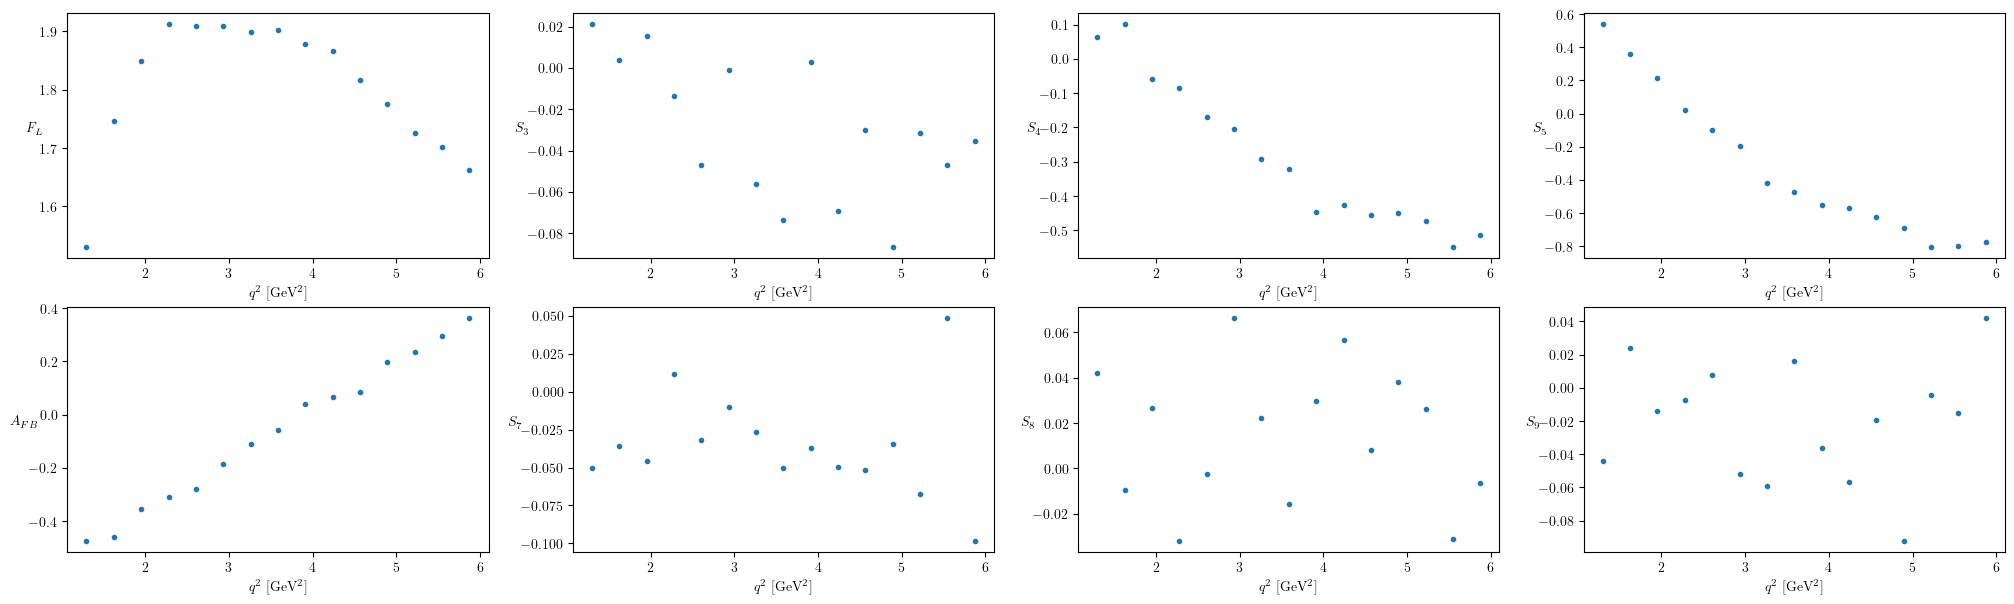

In [117]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (25,7))
_i = 0
for _row in ax:
    for _col in _row:
        _col.plot(r_bins[1][0:15]+0.2, (5/2) * mom_bins[obsList[_i]][0]/r_bins[0], '.')
        _col.set_xlabel("$q^{2}$ [GeV$^{2}$]")
        _col.set_ylabel(obs_to_label[obsList[_i]], rotation=0)
        _i += 1

In [118]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn import neighbors
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d 

In [119]:
#kernel = DotProduct() + WhiteKernel()
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

In [138]:
knn = neighbors.KNeighborsRegressor(400, weights="uniform")
#gpr = GaussianProcessRegressor(kernel=kernel,
#         random_state=0).fit(np.array(infile['q2'][:1000]).reshape(1000,1), infile['moment_5'][:1000])


In [139]:
#mean_prediction, std_prediction = gpr.predict(np.array(infile['q2'][:1000]).reshape(1000,1), return_std=True)
T = np.linspace(1.1,6.0,10000)[:, np.newaxis]
unbins = {}
for _s in range(200):
    unbins[_s] = {}
    tsample = infile.sample(20000)
    for _obs in obsList:
        unbins[_s][_obs] = knn.fit(np.array(tsample['q2']).reshape(20000,1), tsample['moment_%s' % _obs][:20000]).predict(T)

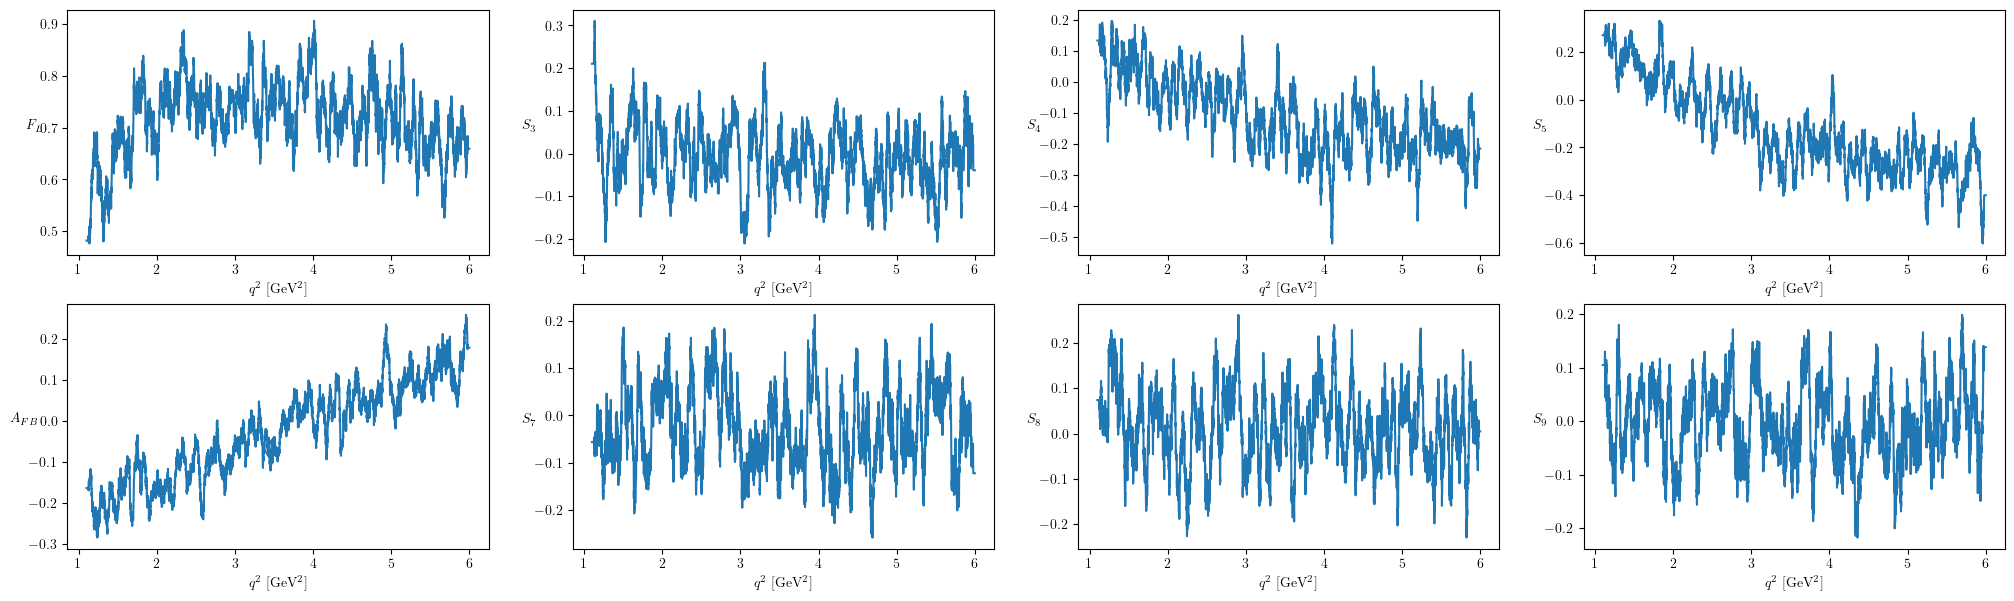

In [122]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (25,7))
_i = 0
for _row in ax:
    for _col in _row:
        _col.plot(T, unbins[0][obsList[_i]])
        _col.set_xlabel("$q^{2}$ [GeV$^{2}$]")
        _col.set_ylabel(obs_to_label[obsList[_i]], rotation=0)
        _i += 1

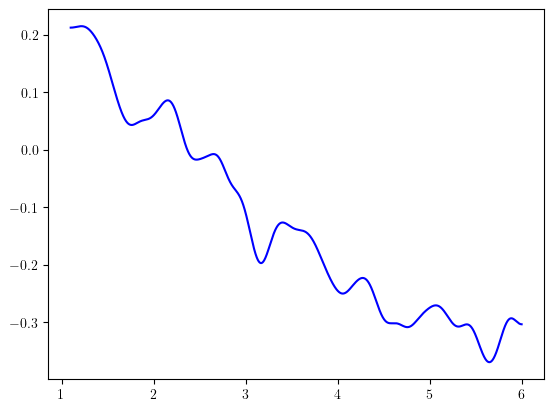

In [79]:
plt.plot(T, gaussian_filter1d(unbins[80]['S5'], sigma=200), color='b')

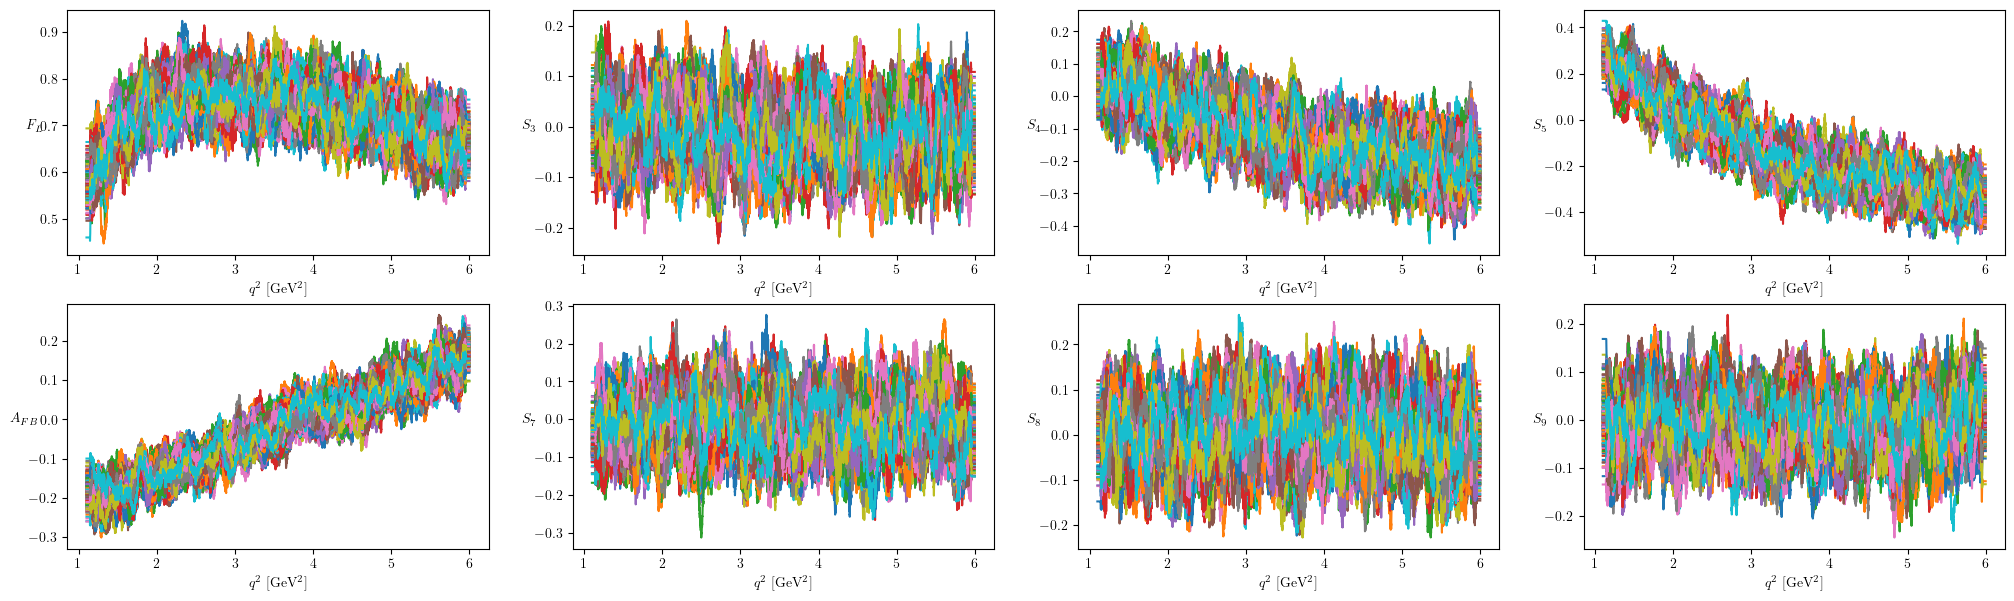

In [150]:
filtered_unbins = {}
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (25,7))
_i = 0
for _row in ax:
    for _col in _row:
        _obs = obsList[_i]
        filtered_unbins[_obs] = {}
        for _s in range(200):
            filtered_unbins[_obs][_s] = gaussian_filter1d(unbins[_s][_obs], sigma=200)
            _col.plot(T, unbins[_s][_obs])
        _col.set_xlabel("$q^{2}$ [GeV$^{2}$]")
        _col.set_ylabel(obs_to_label[obsList[_i]], rotation=0)
        _i += 1

In [151]:
mean_vals = {}
lower_vals = {}
upper_vals = {}
sigma_vals = {}
for _obs in obsList:
    mean_vals[_obs] = []
    lower_vals[_obs] = []
    upper_vals[_obs] = []
    sigma_vals[_obs] = []
for _v in range(10000):
    for _obs in obsList:
        ordered = [unbins[_s][_obs][_v] for _s in range(200)]
        ordered.sort()
        mean_vals[_obs].append(np.mean(ordered))
        lower_vals[_obs].append(ordered[32])
        upper_vals[_obs].append(ordered[168])
        sigma_vals[_obs].append(0.5*abs(upper_vals[_obs][-1] - lower_vals[_obs][-1]))

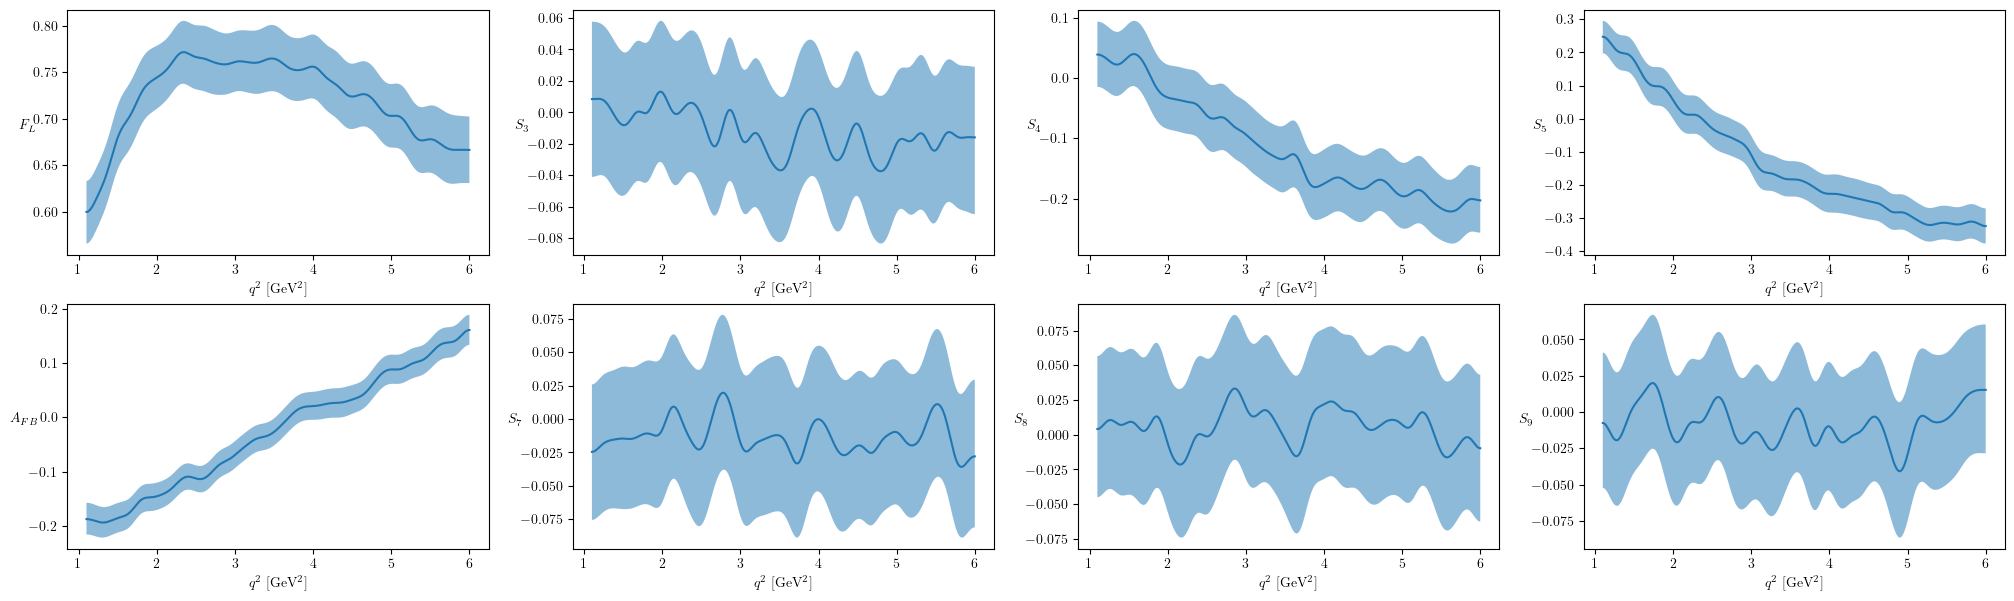

In [152]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (25,7))
_i = 0
for _row in ax:
    for _col in _row:
        _obs = obsList[_i]
        _col.plot(T, gaussian_filter1d(mean_vals[_obs], sigma=200))
        _col.fill_between(T.reshape(10000), gaussian_filter1d(lower_vals[_obs], sigma=200), gaussian_filter1d(upper_vals[_obs], sigma=200), alpha = 0.5)
        _col.set_xlabel("$q^{2}$ [GeV$^{2}$]")
        _col.set_ylabel(obs_to_label[obsList[_i]], rotation=0)
        _i += 1

In [83]:
from sklearn.neighbors import BallTree

In [84]:
 tree = BallTree(np.array(tsample['q2']).reshape(20000,1), leaf_size=2)

In [85]:
dist, ind = tree.query([[1.211]], k=400)

In [86]:
def moment5_var(indices, moment):
    rs = infile.loc[indices[0]]
    angles = 0.4 * moment - np.sqrt(1. - rs['ctl']*rs['ctl']) * 2 * rs['ctk'] * np.sqrt(1. - rs['ctk']*rs['ctk']) * np.cos(rs['phi'])
    tsum = np.sum(angles**2)
    return 2.5*np.sqrt((1./(299.*300.))*tsum)

In [87]:
moms5_var = moment5_var(ind, 0.)

In [88]:
tvars = []
_i = 0
for _q2 in T.reshape(10000):
    _, ind = tree.query([[_q2]], k=400)
    tvars.append(0.5*moment5_var(ind, mean_vals['S5'][_i]))
    _i+=1

In [153]:
current = {
    'S2c' : [-4.4444292e-08/6.17831e-8, -5.0072838e-08/6.29868e-8 , -6.8838896e-08/9.41826e-8],
    'S3' : [0.0089049437, -0.0085131542, -0.023252104],
    'S4' : [-0.010349509, -0.13171753, -0.21123314],
    'S5' : [6.9419e-9/6.17831e-8, -9.46732e-9/6.29868e-8, -2.94643e-8/9.41826e-8],
    'AFB' : [-0.1802, -0.07505, 0.07095],
    'S7' : [-0.016736809, -0.012995330, -0.013370855],
    'S8' : [-0.0038672801, -0.0035376542, -0.0016877821],
    'S9' : [-0.0038677392, -0.00098096590, 0.00050010764],
    'FL' : [4.4444292e-08/6.17831e-8, 5.0072838e-08/6.29868e-8 , 6.8838896e-08/9.41826e-8]
}
current_err = {
    'S2c' : [0.02178, 0.01954, 0.01597],
    'FL' : [0.02178, 0.01954, 0.01597],
    'S3' : [0.02416, 0.02357, 0.01945],
    'S4' : [0.03483, 0.03295, 0.02402],
    'S5' : [0.03241, 0.03179, 0.02374],
    'AFB' : [0.0197, 0.01717, 0.01403],
    'S7' : [0.03268, 0.0327, 0.02602],
    'S8' : [0.03516, 0.03383, 0.02633],
    'S9' : [0.02404, 0.02353, 0.01952]
}
current_q2_centre = [1.8, 3.25, 5.0]
current_q2_width = [0.7, 0.75, 1.0]

" \nfor _v in obsList:\n    plt.figure(figsize = (5,5))\n    plt.plot(T, mean_vals[_v])\n    #plt.fill_between(T.reshape(10000), np.subtract(mean_vals,tvars), np.add(mean_vals, tvars), alpha = 0.5, label = 'LHCb unbinned projected 30fb$^{-1}$')\n    plt.fill_between(T.reshape(10000), lower_vals[_v], upper_vals[_v], alpha = 0.5, label = 'LHCb unbinned 30fb$^{-1}$')\n    plt.errorbar(current_q2_centre, current[_v], yerr = current_err[_v], xerr = current_q2_width, label = 'LHCb binned 9fb$^{-1}$', linestyle = '')\n    plt.ylabel(obs_to_label[_v], fontsize = 20, rotation = 0)\n    plt.xlabel('$q^{2}$ [GeV$^{2}$]', fontsize = 20)\n    plt.legend(fontsize=16, frameon=False, markerfirst=False)\n    plt.xticks(fontsize=14)\n    plt.yticks(fontsize=14)\n    plt.tight_layout()\n    plt.savefig('unbinned_S5.png')\n"

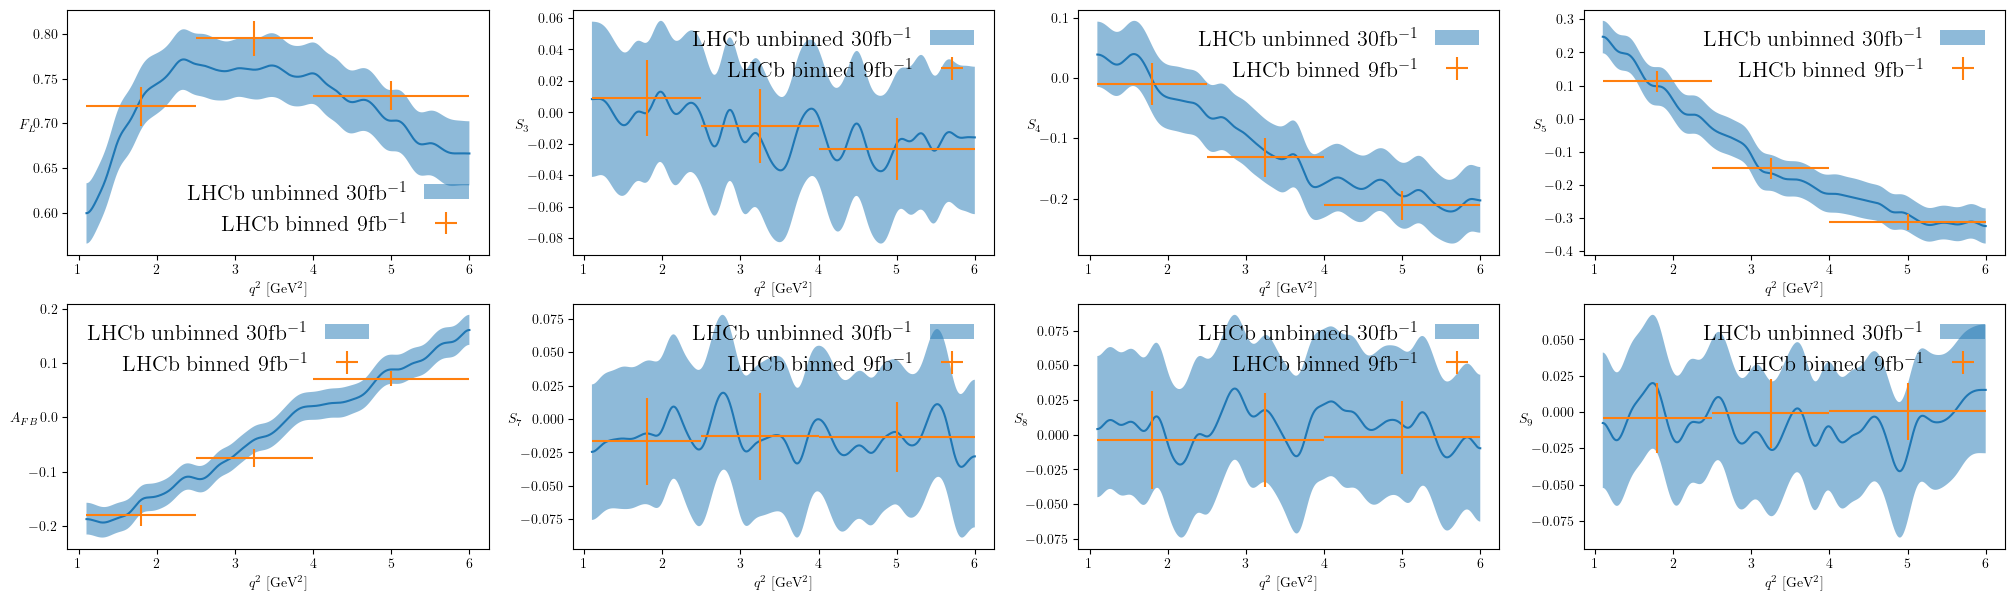

In [154]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (25,7))
_i = 0
for _row in ax:
    for _col in _row:
        _obs = obsList[_i]
        _col.plot(T, gaussian_filter1d(mean_vals[_obs], sigma=200))
        _col.fill_between(T.reshape(10000), gaussian_filter1d(lower_vals[_obs], sigma=200), gaussian_filter1d(upper_vals[_obs], sigma=200), alpha = 0.5, label = 'LHCb unbinned 30fb$^{-1}$')
        _col.errorbar(current_q2_centre, current[_obs], yerr = current_err[_obs], xerr = current_q2_width, label = 'LHCb binned 9fb$^{-1}$', linestyle = '')
        _col.set_xlabel("$q^{2}$ [GeV$^{2}$]")
        _col.set_ylabel(obs_to_label[obsList[_i]], rotation=0)
        _col.legend(fontsize=16, frameon=False, markerfirst=False)
        _i += 1
""" 
for _v in obsList:
    plt.figure(figsize = (5,5))
    plt.plot(T, mean_vals[_v])
    #plt.fill_between(T.reshape(10000), np.subtract(mean_vals,tvars), np.add(mean_vals, tvars), alpha = 0.5, label = 'LHCb unbinned projected 30fb$^{-1}$')
    plt.fill_between(T.reshape(10000), lower_vals[_v], upper_vals[_v], alpha = 0.5, label = 'LHCb unbinned 30fb$^{-1}$')
    plt.errorbar(current_q2_centre, current[_v], yerr = current_err[_v], xerr = current_q2_width, label = 'LHCb binned 9fb$^{-1}$', linestyle = '')
    plt.ylabel(obs_to_label[_v], fontsize = 20, rotation = 0)
    plt.xlabel('$q^{2}$ [GeV$^{2}$]', fontsize = 20)
    plt.legend(fontsize=16, frameon=False, markerfirst=False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig('unbinned_S5.png')
"""

In [146]:
import json
with open('means.json', 'w') as fp:
    json.dump(mean_vals, fp)
with open('sigmas.json', 'w') as fp:
    json.dump(sigma_vals, fp)

In [155]:
filtered_unbins

{'FL': {0: array([0.58944856, 0.58944858, 0.58944864, ..., 0.67748264, 0.67748415,
         0.67748491]),
  1: array([0.61370108, 0.61370191, 0.61370356, ..., 0.6545121 , 0.65451092,
         0.65451033]),
  2: array([0.61125746, 0.61125744, 0.61125738, ..., 0.67868879, 0.67868816,
         0.67868785]),
  3: array([0.5534444 , 0.55344503, 0.55344628, ..., 0.67611542, 0.67611515,
         0.67611501]),
  4: array([0.62838609, 0.62838678, 0.62838817, ..., 0.65681582, 0.65681526,
         0.65681498]),
  5: array([0.59683847, 0.59683867, 0.59683908, ..., 0.68648677, 0.68648746,
         0.68648781]),
  6: array([0.60330051, 0.60330077, 0.60330129, ..., 0.69735482, 0.69735589,
         0.69735643]),
  7: array([0.62913277, 0.62913313, 0.62913385, ..., 0.62440366, 0.62440136,
         0.62440021]),
  8: array([0.60055297, 0.60055258, 0.60055182, ..., 0.6869451 , 0.68694601,
         0.68694647]),
  9: array([0.59513461, 0.59513527, 0.59513659, ..., 0.69196116, 0.6919607 ,
         0.691960

In [156]:
s5_point_10 = [filtered_unbins['S5'][_s][10] for _s in range(200)]
s5_point_100 = [filtered_unbins['S5'][_s][100] for _s in range(200)]
s4_point_10 = [filtered_unbins['S4'][_s][10] for _s in range(200)]
s4_point_100 = [filtered_unbins['S4'][_s][100] for _s in range(200)]

In [157]:
np.cov([s5_point_10,s5_point_100, s4_point_10, s4_point_100])

array([[ 0.00120847,  0.00114548, -0.00020702, -0.00018846],
       [ 0.00114548,  0.00109282, -0.00020251, -0.00018593],
       [-0.00020702, -0.00020251,  0.00133342,  0.00126497],
       [-0.00018846, -0.00018593,  0.00126497,  0.00120869]])

In [158]:
points = {}
for _v in obsList:
    points[_v] = {}
    for _p in range(10000):
        points[_v][_p] = [filtered_unbins[_v][_s][_p] for _s in range(200)]

In [159]:
points.keys()

dict_keys(['FL', 'S3', 'S4', 'S5', 'AFB', 'S7', 'S8', 'S9'])

In [160]:
np.corrcoef([points['S5'][_v] for _v in [1,100,1000,5000,9000]])

array([[ 1.        ,  0.99669847, -0.05907745, -0.11574597, -0.08657847],
       [ 0.99669847,  1.        , -0.05014288, -0.11596541, -0.08308876],
       [-0.05907745, -0.05014288,  1.        , -0.01401003,  0.13622552],
       [-0.11574597, -0.11596541, -0.01401003,  1.        ,  0.13196155],
       [-0.08657847, -0.08308876,  0.13622552,  0.13196155,  1.        ]])

In [161]:
with open('covs.json', 'w') as fp:
    json.dump(points, fp)

In [207]:
to_calculate = {}
for _v in obsList:
    for _p in range(0,10000,10):
        to_calculate["%s_%s" % (_v,_p)] = points[_v][_p]
for_cov = pd.DataFrame(to_calculate)

In [208]:
for_cov

,FL_0,FL_10,FL_20,FL_30,FL_40,FL_50,FL_60,FL_70,FL_80,FL_90,...,S9_9900,S9_9910,S9_9920,S9_9930,S9_9940,S9_9950,S9_9960,S9_9970,S9_9980,S9_9990
0,0.589449,0.589450,0.589455,0.589462,0.589473,0.589489,0.589510,0.589537,0.589572,0.589616,...,0.023933,0.024904,0.025783,0.026568,0.027255,0.027841,0.028323,0.028699,0.028966,0.029125
1,0.613701,0.613747,0.613875,0.614084,0.614375,0.614744,0.615191,0.615712,0.616307,0.616970,...,0.036712,0.037177,0.037605,0.037991,0.038333,0.038627,0.038872,0.039063,0.039200,0.039282
2,0.611257,0.611256,0.611250,0.611242,0.611230,0.611215,0.611198,0.611178,0.611157,0.611134,...,0.036778,0.036841,0.036887,0.036921,0.036944,0.036959,0.036969,0.036974,0.036977,0.036979
3,0.553444,0.553479,0.553577,0.553737,0.553960,0.554247,0.554597,0.555010,0.555487,0.556027,...,0.033281,0.033757,0.034194,0.034588,0.034935,0.035234,0.035481,0.035674,0.035813,0.035896
4,0.628386,0.628424,0.628531,0.628706,0.628947,0.629252,0.629618,0.630043,0.630521,0.631050,...,0.017956,0.017395,0.016887,0.016432,0.016035,0.015697,0.015419,0.015202,0.015047,0.014955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.584449,0.584508,0.584673,0.584943,0.585318,0.585793,0.586367,0.587036,0.587796,0.588642,...,-0.021982,-0.022437,-0.022849,-0.023217,-0.023539,-0.023813,-0.024039,-0.024215,-0.024341,-0.024415
196,0.560304,0.560361,0.560523,0.560788,0.561156,0.561627,0.562199,0.562872,0.563645,0.564517,...,0.035984,0.037383,0.038664,0.039818,0.040835,0.041709,0.042431,0.042997,0.043401,0.043642
197,0.632798,0.632773,0.632703,0.632587,0.632428,0.632224,0.631978,0.631690,0.631362,0.630996,...,-0.015524,-0.016178,-0.016779,-0.017322,-0.017802,-0.018215,-0.018558,-0.018827,-0.019019,-0.019134
198,0.584829,0.584866,0.584970,0.585141,0.585379,0.585682,0.586048,0.586478,0.586968,0.587517,...,0.038378,0.038750,0.039086,0.039385,0.039646,0.039868,0.040050,0.040193,0.040294,0.040354


In [ ]:
correlation_matrix = for_cov.corr()
correlation_matrix.to_json("correlation_matrix.json", indent = 4)

In [206]:
covariance_matrix = for_cov.cov()
covariance_matrix.to_json("covariance_matrix.json", indent = 4)

,FL_0,FL_10,FL_20,FL_30,FL_40,FL_50,FL_60,FL_70,FL_80,FL_90,...,S9_9900,S9_9910,S9_9920,S9_9930,S9_9940,S9_9950,S9_9960,S9_9970,S9_9980,S9_9990
FL_0,0.000608,0.000607,0.000606,0.000604,0.000602,0.000599,0.000595,0.000590,0.000585,0.000579,...,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000030,0.000030,0.000030,0.000030
FL_10,0.000607,0.000607,0.000606,0.000604,0.000601,0.000598,0.000594,0.000590,0.000584,0.000579,...,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000030,0.000030,0.000030,0.000030
FL_20,0.000606,0.000606,0.000605,0.000603,0.000600,0.000597,0.000593,0.000589,0.000583,0.000578,...,0.000031,0.000031,0.000031,0.000031,0.000031,0.000030,0.000030,0.000030,0.000030,0.000030
FL_30,0.000604,0.000604,0.000603,0.000601,0.000599,0.000595,0.000592,0.000587,0.000582,0.000576,...,0.000031,0.000031,0.000031,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030
FL_40,0.000602,0.000601,0.000600,0.000599,0.000596,0.000593,0.000589,0.000585,0.000580,0.000574,...,0.000031,0.000031,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S9_9950,0.000031,0.000031,0.000030,0.000030,0.000030,0.000030,0.000029,0.000029,0.000029,0.000028,...,0.000866,0.000878,0.000888,0.000898,0.000906,0.000913,0.000919,0.000923,0.000926,0.000928
S9_9960,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000029,0.000029,0.000028,0.000028,...,0.000871,0.000883,0.000894,0.000903,0.000911,0.000919,0.000924,0.000929,0.000932,0.000934
S9_9970,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000029,0.000029,0.000028,0.000028,...,0.000875,0.000887,0.000898,0.000907,0.000916,0.000923,0.000929,0.000933,0.000937,0.000939
S9_9980,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000029,0.000029,0.000028,0.000028,...,0.000878,0.000890,0.000901,0.000910,0.000919,0.000926,0.000932,0.000937,0.000940,0.000942


In [2]:
smoothed_mean_vals = {}
smoothed_sigma_vals = {}
for _o in obsList:
    smoothed_mean_vals[_o] = gaussian_filter1d(mean_vals[_o], sigma=200)
    smoothed_sigma_vals[_o] = gaussian_filter1d(sigma_vals[_o], sigma=200)

NameError: name 'obsList' is not defined